In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
import spacy
import matplotlib.pyplot as plt
import gc
from keras_preprocessing import text
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
#For matplotlib to work
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
fake_news = pd.read_csv("News/Fake.csv")
true_news = pd.read_csv("News/True.csv")

In [5]:
fake_news["legit"] = 0
true_news["legit"] = 1

In [6]:
SAMPLE_SIZE = 21417
data = pd.concat([true_news.sample(SAMPLE_SIZE),fake_news.sample(SAMPLE_SIZE)])
data

,title,text,subject,date,legit
10074,"Behind Donald Trump, a son-in-law who is also ...",NEW YORK (Reuters) - Before introducing Donald...,politicsNews,"April 4, 2016",1
1163,Republican Senator Hatch rejects bipartisan he...,WASHINGTON (Reuters) - U.S. Senate Finance Com...,politicsNews,"October 18, 2017",1
1807,Vice President Pence: Trump greatly concern ab...,WASHINGTON (Reuters) - U.S. Vice President Mik...,politicsNews,"September 10, 2017",1
18501,Uzbek dissident denies anti-government propaga...,TASHKENT (Reuters) - Uzbek dissident writer Nu...,worldnews,"October 2, 2017",1
13351,Three migrants die in boat accident off Morocc...,"RABAT (Reuters) - At least 3 migrants, two of ...",worldnews,"December 1, 2017",1
...,...,...,...,...,...
1068,While Trying To Brag Trump Jr Accidentally Sh...,"Like father, like son, Donald Trump Jr. twitte...",News,"June 21, 2017",0
12430,WOW! ONE COURAGEOUS MAN Stands Against Rioters...,,politics,"Nov 11, 2016",0
1516,Trump Spotted Hanging Up Easily The Most Path...,By generous accounts Trump is facing a scandal...,News,"May 11, 2017",0
18570,DONALD RUMSELD HUMILIATES “The View” Dingbat J...,There is no question that Whoopi Goldberg is a...,left-news,"May 28, 2017",0


In [7]:
data.drop("date",axis=1,inplace=True)
data.drop("subject",axis=1,inplace=True)

In [8]:
data

,title,text,legit
10074,"Behind Donald Trump, a son-in-law who is also ...",NEW YORK (Reuters) - Before introducing Donald...,1
1163,Republican Senator Hatch rejects bipartisan he...,WASHINGTON (Reuters) - U.S. Senate Finance Com...,1
1807,Vice President Pence: Trump greatly concern ab...,WASHINGTON (Reuters) - U.S. Vice President Mik...,1
18501,Uzbek dissident denies anti-government propaga...,TASHKENT (Reuters) - Uzbek dissident writer Nu...,1
13351,Three migrants die in boat accident off Morocc...,"RABAT (Reuters) - At least 3 migrants, two of ...",1
...,...,...,...
1068,While Trying To Brag Trump Jr Accidentally Sh...,"Like father, like son, Donald Trump Jr. twitte...",0
12430,WOW! ONE COURAGEOUS MAN Stands Against Rioters...,,0
1516,Trump Spotted Hanging Up Easily The Most Path...,By generous accounts Trump is facing a scandal...,0
18570,DONALD RUMSELD HUMILIATES “The View” Dingbat J...,There is no question that Whoopi Goldberg is a...,0


In [10]:
nlp = spacy.load('en_core_web_lg')
def preprocess(text):
    doc = nlp(text)
    buffer = []
    for word in doc:
        if (word.is_alpha or word.is_digit) and not word.like_email and not word.like_url and not word.like_num and not word.is_stop and len(word.text) >1:
            buffer.append(word.lemma_.lower())
    
    return ' '.join(buffer)

In [11]:
data["Treated_title"] = data['text'].apply(preprocess)
data

,title,text,legit,Treated_title
10074,"Behind Donald Trump, a son-in-law who is also ...",NEW YORK (Reuters) - Before introducing Donald...,1,new york reuters introduce donald trump roughl...
1163,Republican Senator Hatch rejects bipartisan he...,WASHINGTON (Reuters) - U.S. Senate Finance Com...,1,washington reuters senate finance committee ch...
1807,Vice President Pence: Trump greatly concern ab...,WASHINGTON (Reuters) - U.S. Vice President Mik...,1,washington reuters vice president mike pence s...
18501,Uzbek dissident denies anti-government propaga...,TASHKENT (Reuters) - Uzbek dissident writer Nu...,1,tashkent reuters uzbek dissident writer nurull...
13351,Three migrants die in boat accident off Morocc...,"RABAT (Reuters) - At least 3 migrants, two of ...",1,rabat reuters migrant woman die boat sink moro...
...,...,...,...,...
1068,While Trying To Brag Trump Jr Accidentally Sh...,"Like father, like son, Donald Trump Jr. twitte...",0,like father like son donald trump twitter acco...
12430,WOW! ONE COURAGEOUS MAN Stands Against Rioters...,,0,
1516,Trump Spotted Hanging Up Easily The Most Path...,By generous accounts Trump is facing a scandal...,0,generous account trump face scandal inflammato...
18570,DONALD RUMSELD HUMILIATES “The View” Dingbat J...,There is no question that Whoopi Goldberg is a...,0,question whoopi goldberg talented actress abil...


In [12]:
x_train,x_test,y_train,y_test = train_test_split(data.text.values,data.legit.values,test_size=0.2,shuffle=True)

In [15]:
MAX_WORDS = 10000
MAX_LEN = 300

In [16]:
tokenizer = text.Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=MAX_LEN)

In [17]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=MAX_LEN)

In [18]:
class News(Dataset):
    def __init__(self,features,labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,x):
        return torch.tensor(self.features[x]),torch.tensor(self.labels[x])

In [19]:
trainDataset = News(x_train,y_train)
testDataset = News(X_test,y_test)

In [20]:
BATCH_SIZE = 128
trainDataloader = DataLoader(trainDataset,batch_size=BATCH_SIZE)
testDataloader = DataLoader(testDataset,batch_size=BATCH_SIZE,shuffle=True)

In [21]:
class Block(nn.Module):
    def __init__(self,n_embd,num_heads):
        super().__init__()
        self.multi_head_att = nn.MultiheadAttention(embed_dim=n_embd,num_heads=num_heads,dropout=0.2,
                                                    batch_first=True,device=device)
        self.norm1 = nn.LayerNorm(n_embd)
        self.FFW = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.2),
        )
        self.norm2 = nn.LayerNorm(n_embd)
        
    def forward(self,x):
        pure = x
        x , _ = self.multi_head_att(x,x,x)
        x = self.norm1(x+pure)
        pure = x
        x = self.FFW(x)
        x = self.norm2(x+pure)
        return x

In [22]:
class ModelV1(nn.Module):
    def __init__(self,inpt,n_embd,num_heads,n_layer,outputs):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(MAX_WORDS, n_embd)
        self.position_embedding_table = nn.Embedding(inpt, n_embd)
#         self.block = Block(n_embd,num_heads)
        self.blocks = nn.Sequential(*[Block(n_embd,num_heads=num_heads) for _ in range(n_layer)])
        self.lm_head = nn.Linear(in_features=n_embd,out_features=outputs)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self,idx):
        B,T= idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        idx = tok_emb + pos_emb
        
#         idx = self.block(idx)
        idx=self.blocks(idx)
        
        idx = self.lm_head(idx)
        return idx
    

In [23]:
model = ModelV1(inpt=MAX_LEN,n_embd=128,num_heads=8,n_layer=6,outputs=1)
model.to(device)
model.parameters

<bound method Module.parameters of ModelV1(
  (token_embedding_table): Embedding(10000, 128)
  (position_embedding_table): Embedding(300, 128)
  (blocks): Sequential(
    (0): Block(
      (multi_head_att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (FFW): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
        (3): Dropout(p=0.2, inplace=False)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Block(
      (multi_head_att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (FFW): Sequential(
        (0): Linear(in_features=128

In [24]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

In [25]:
def calculate_accuracy(predicted_labels, true_labels):
    if len(predicted_labels) != len(true_labels):
        raise ValueError("Number of predicted labels does not match the number of true labels.")
    
    correct_predictions = 0
    total_predictions = len(predicted_labels)
    
    for predicted, true in zip(predicted_labels, true_labels):
        if predicted == true:
            correct_predictions += 1
    
    accuracy = correct_predictions / total_predictions
    return accuracy


In [26]:
lossTs_list = []
lossTr_list = []

In [27]:
epochs = 2
for epoch in range(epochs):
    lossTr = 0
    lossTs = 0
    accuT =0
    model.train()
    for btr,(X,y) in tqdm(enumerate(trainDataloader)):
        X,y = X.to(device),y.to(device)
        
        logits = model(X)
        preds = torch.sigmoid(logits)
        preds = (preds>0.7).int()
        loss = loss_fn(logits[:,-1,:],y.unsqueeze(1).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        
        lossTr += loss
        
    with torch.inference_mode():
        model.eval()
        for bts,(X,y) in tqdm(enumerate(testDataloader)):
            X,y = X.to(device),y.to(device)

            logits = model(X)
            preds = torch.sigmoid(logits)
            preds = (preds>0.7).int()
            loss = loss_fn(logits[:,-1,:],y.unsqueeze(1).float())

            accu = calculate_accuracy(y.unsqueeze(1).cpu(),preds[:,-1,:].cpu())

            lossTs += loss
            accuT += accu
        
    print(f"Epoch {epoch+1}/{epochs} : Train loss is {lossTr.cpu()/(btr+1)} || Test loss is {lossTs.cpu()/(bts+1)} :: Accuracy is {accuT/(bts+1)}")
    lossTr_list.append(lossTr/(btr+1))
    lossTs_list.append(lossTs/(bts+1))

268it [13:01,  2.92s/it]
67it [01:00,  1.11it/s]


Epoch 1/2 : Train loss is 0.07646358013153076 || Test loss is 0.0172035600990057 :: Accuracy is 0.9946361940298507


268it [13:00,  2.91s/it]
67it [01:00,  1.11it/s]

Epoch 2/2 : Train loss is 0.009932327084243298 || Test loss is 0.020200075581669807 :: Accuracy is 0.9955690298507462


In [36]:
epochs_list = np.arange(2)+1

In [37]:
for i in range(len(lossTr_list)):
    lossTr_list[i] = lossTr_list[i].detach().cpu()
    lossTs_list[i] = lossTs_list[i].cpu()

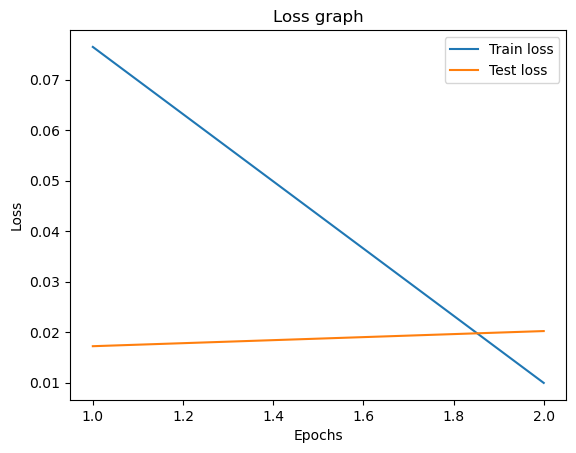

In [38]:
plt.plot(epochs_list, lossTr_list, label = "Train loss")
plt.plot(epochs_list,lossTs_list, label = "Test loss")
  
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Loss graph')
plt.legend()
plt.show()

In [31]:
with torch.inference_mode():
        model.eval()
        for bts,(X,y) in enumerate(testDataloader):
            X,y = X.to(device),y.to(device)

            logits = model(X)
            preds = torch.sigmoid(logits)
            preds = (preds>0.7).int()
            
            for i in range(len(y)):
                print(f"The label was : {y[i]} || Predicted :{preds[i,-1,:].item()} with chance : {torch.sigmoid(logits)[i,-1,:].item()} ==> {y[i]}{preds[i,-1,:].item()}")
            break

The label was : 0 || Predicted :0 with chance : 0.0004988429718650877 ==> 00
The label was : 0 || Predicted :0 with chance : 0.0003908219514414668 ==> 00
The label was : 0 || Predicted :0 with chance : 0.0006816760287620127 ==> 00
The label was : 1 || Predicted :1 with chance : 0.9995325803756714 ==> 11
The label was : 1 || Predicted :1 with chance : 0.9995631575584412 ==> 11
The label was : 0 || Predicted :0 with chance : 0.0005008404841646552 ==> 00
The label was : 0 || Predicted :0 with chance : 0.0003751284384634346 ==> 00
The label was : 0 || Predicted :0 with chance : 0.0010833084816113114 ==> 00
The label was : 1 || Predicted :1 with chance : 0.9995599389076233 ==> 11
The label was : 0 || Predicted :0 with chance : 0.0015823021531105042 ==> 00
The label was : 1 || Predicted :1 with chance : 0.9994949102401733 ==> 11
The label was : 0 || Predicted :0 with chance : 0.00036879946128465235 ==> 00
The label was : 0 || Predicted :0 with chance : 0.0005399860674515367 ==> 00
The label 